# <center> Задание 11.11. Модуль MATH&ML-13 (HW-02)
---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 4. Статистические модели прогнозирования. Практика

1\. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

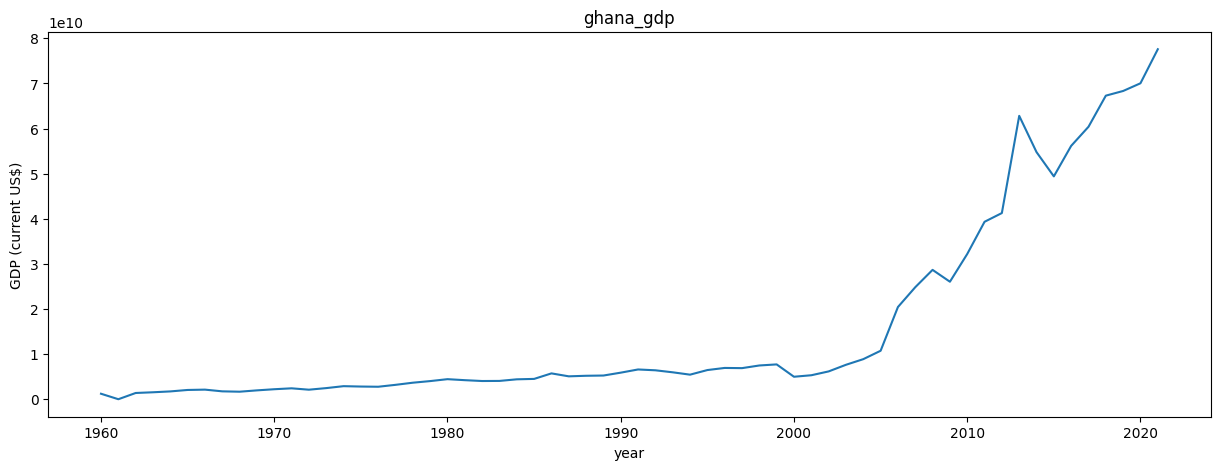

In [76]:
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=['year'], index_col='year').asfreq('YS-JAN')
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(data)
ax.set_xlabel('year')
ax.set_ylabel('GDP (current US$)')
ax.set_title('ghana_gdp')
plt.show()

Наблюдается явный тренд, сезонность не прослеживается.

2\. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
> **Пример**: `train_df.spx.rolling(window=2).mean()`

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

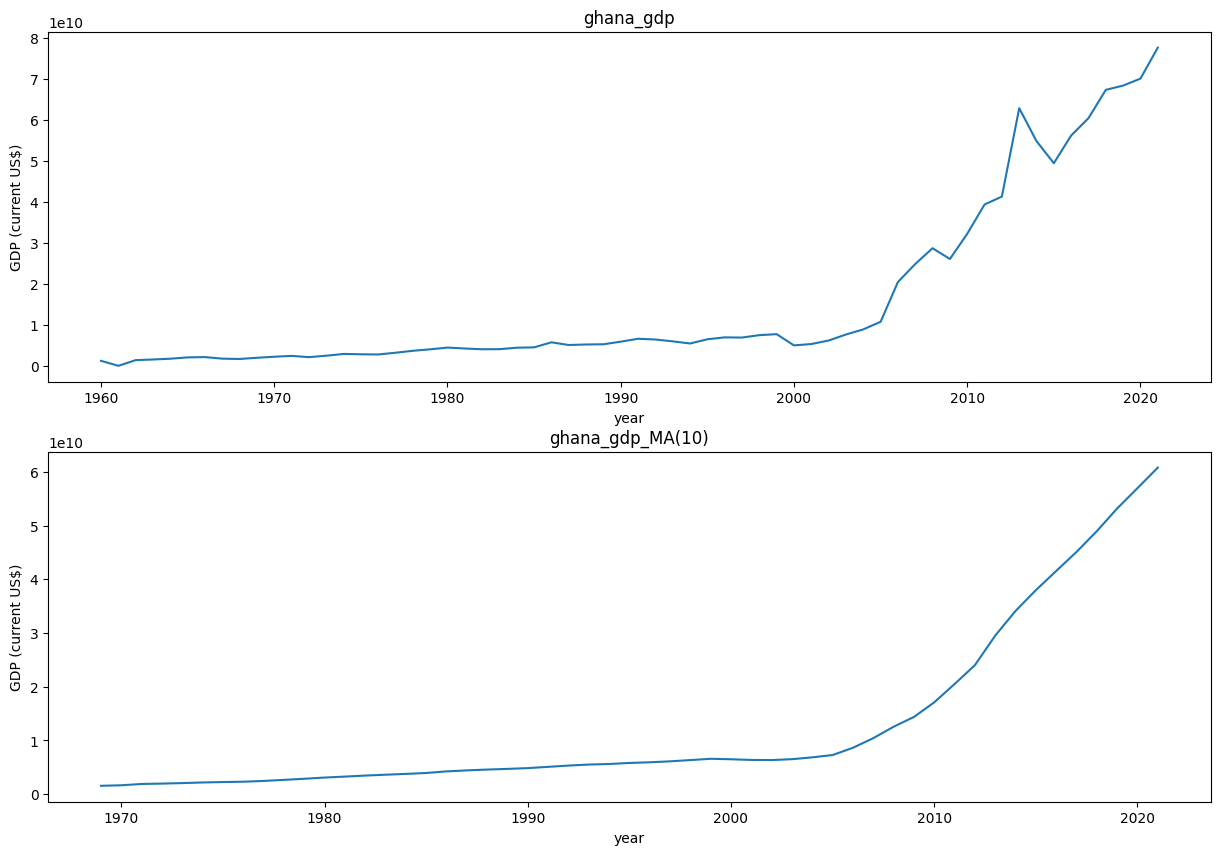

In [77]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
ax[0].plot(data)
ax[0].set_xlabel('year')
ax[0].set_ylabel('GDP (current US$)')
ax[0].set_title('ghana_gdp')
ax[1].plot(data.rolling(window=10).mean())
ax[1].set_xlabel('year')
ax[1].set_ylabel('GDP (current US$)')
ax[1].set_title('ghana_gdp_MA(10)')
plt.show()

Т.к. изначальный ряд довольно гладкий, то использоваине простого скользящего среднего не даёт преимуществ. А если поставить широкое окно, то мы просто теряем информацию.

3\. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели *ARMA/ARIMA*.
> **Примечание**. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром *d* для модели *ARIMA*.

Параметры *p* и *q* выберите по коррелограммам *ACF* и *PACF*.
> **Примечание**. Помните, что параметры *p* и *q* для *ARMA/ARIMA* определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель *ARMA/ARIMA* для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным *p* и *q*, и сравните коэффициент *AIC* (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

In [78]:
from statsmodels.tsa.stattools import adfuller

def get_stationarity(data, d=0):
    # Удаляем NaN
    data = data.dropna()
    # Проводим тест Дики-Фуллера
    adf = adfuller(data.values)
    # Сравниваем с самым большим из критических значений
    if adf[0] >= adf[4]['10%']:
        data = data.diff()
        # Если ряд нестационарен, применяем функцию ещё раз
        return get_stationarity(data, d+1)
    else:
        print(f'ADF Statistics: {adf[0]}')
        print(f'p-value: {adf[1]}')
        print(f'Critical Values:')
        for key, value in adf[4].items():
            print(f'\t{key}: {value:.3f}')
        print(f'\nРяд стационарен на уровне порядка интегрирования {d}')
        stat_data = data
    # Возвращаем разность и порядок
    return stat_data, d

stat_data, d = get_stationarity(data)

ADF Statistics: -5.278476343687468
p-value: 6.066691711555073e-06
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599

Ряд стационарен на уровне порядка интегрирования 3


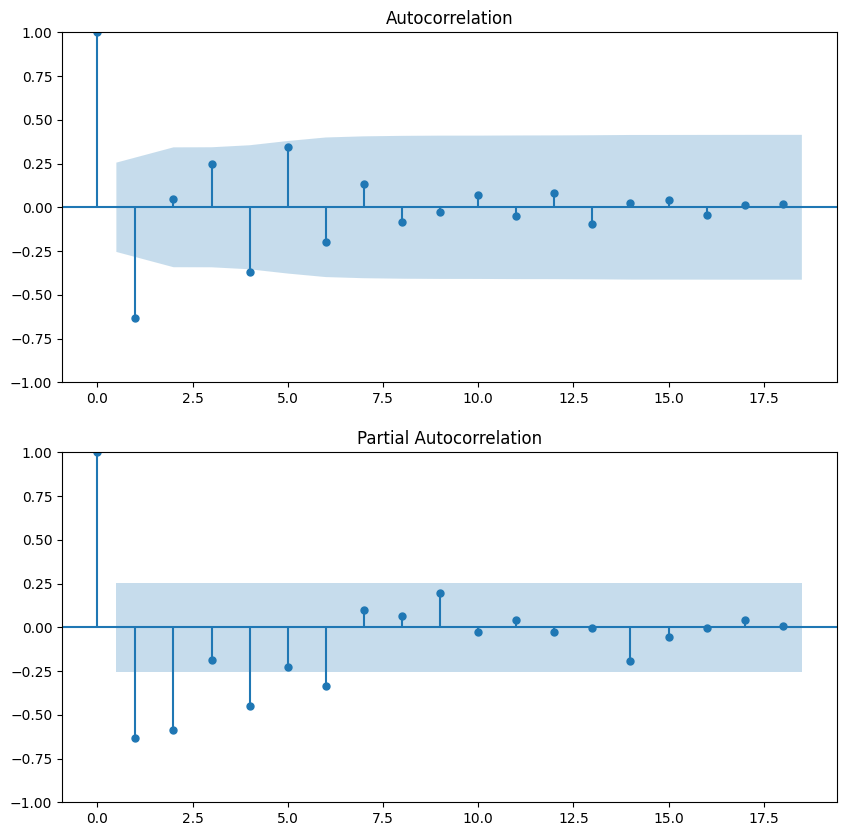

In [79]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
plot_acf(stat_data, ax[0])
plot_pacf(stat_data, ax[1])
plt.show()

p = 6

d = 3

q = 1 

In [106]:
from warnings import filterwarnings
filterwarnings("ignore")

In [108]:
from statsmodels.tsa.arima.model import ARIMA

aic = []
for p in range(5, 8):
    for d in range(2, 5):
        for q in range(0, 3):
            arima = ARIMA(data, order=(p, d, q))
            arima_fit = arima.fit()
            params = {'p': p,
                      'd': d,
                      'q': q,
                      'AIC': round(arima_fit.aic, 2)}
            aic.append(params)
aic_df = pd.DataFrame(aic)
aic_df.sort_values(by='AIC').head(1)

,p,d,q,AIC
25,7,4,1,2751.53


4\. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

5\. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

6\. Сделайте выводы по полученным результатам.